# Covid-19 outbreak tracker
### By Sof Taamallah

---
Last update: April 6th 2020, 21:45 CET

Graphs Updated daily. Text written on april 2nd 2020.

Data source: European Centre for Disease Prevention and Control

---

Importante notes:   

- In the case of France, deaths occuring at hospitals were the only data reported. As of Friday april 3rd, deaths in nursing homes (EHPAD) started to be counted. However, historical nursing home figures were provided as a lump sum and details on when these occured were not provided. In this analysis, only hospital data is shown, as were are mostly interested in the shape of the curve rather than the absolute numbers. When there will be enough data on daily nursing home death toll, these will be added.

---

In [68]:

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [69]:
# import the packages needed, the latest data and understanding the columns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import chart_studio.plotly as py
from scipy.interpolate import spline
from IPython.display import YouTubeVideo


# import the data from ECDC
# European CDC site: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
# data is available daily and updated between 10pm and 11pm Central European Time.

url = 'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-04-06.xlsx'
df = pd.read_excel(url, sheet_name=0, header=0, index_col=0)
list_columns = df.columns.values
#print(list_columns)
df.rename(columns={'countriesAndTerritories':'country'}, inplace=True)


# extract countries
df_china = df[df['country'] == 'China'].copy()
df_france = df[df['country'] == 'France'].copy()
df_italy = df[df['country'] == 'Italy'].copy()
df_spain = df[df['country'] == 'Spain'].copy()
df_usa = df[df['countryterritoryCode'] == 'USA'].copy()
df_netherlands = df[df['country'] == 'Netherlands'].copy()
df_germany = df[df['country'] == 'Germany'].copy()
df_tunisia = df[df['country'] == 'Tunisia'].copy()
df_uk = df[df['geoId'] == 'UK'].copy()
df_korea = df[df['country'] == 'South_Korea'].copy()

# clean up data and outliers
#print(df_china.loc['2020-02-14', 'cases'])
#print(df_china.loc['2020-02-12', 'cases'])
df_china.loc['2020-02-13', 'cases'] = np.mean([4156, 2028])

#print(df_china.loc[df_china.index == '2020-02-13', 'deaths'])
#df_china['deaths'] = np.mean([4156, 2028])
#print(df_china.loc['2020-02-14', 'deaths'])
#print(df_china.loc['2020-02-13', 'deaths'])
df_china.loc['2020-02-13', 'deaths'] = np.mean([13, 254])
df_china.loc['2020-02-14', 'deaths'] = np.mean([13, 254])


df_france.loc['2020-04-04', 'deaths'] = 588
df_france.loc['2020-04-04', 'cases'] = 5233
df_france.loc['2020-04-05', 'deaths'] = 441
df_france.loc['2020-04-05', 'cases'] = 5233
df_france.loc['2020-04-06', 'deaths'] = 357
df_france.loc['2020-04-06', 'cases'] = 1873


df_germany.loc['2020-04-03', 'deaths'] = 124
df_germany.loc['2020-04-03', 'cases'] = 5770
df_germany.loc['2020-04-05', 'deaths'] = 169
df_germany.loc['2020-04-05', 'cases'] = 4933
df_germany.loc['2020-04-06', 'deaths'] = 184
df_germany.loc['2020-04-06', 'cases'] = 5936


In [70]:

#https://www.eficiens.com/covid-19-cases-europe/
#https://fr.wikipedia.org/wiki/Pand%C3%A9mie_de_Covid-19_en_France
#https://www.santepubliquefrance.fr/maladies-et-traumatismes/maladies-et-infections-respiratoires/infection-a-coronavirus/articles/infection-au-nouveau-coronavirus-sars-cov-2-covid-19-france-et-monde
new_row_france = pd.DataFrame({'day':7, 'month':4, 'year':2020, 
                        'cases':3912, 'deaths':605, 'country':'France', 
                        'geoId':'FR', 'countryterritoryCode':'FRA', 'popData2018':66987244.0}, 
                                                            index =['2020-04-07']) 
df_france = pd.concat([new_row_france, df_france]).reset_index(drop = False) 
df_france.set_index('index',inplace=True)
#df_france.head(5)
#____________________________________________


#source: https://github.com/pcm-dpc/COVID-19/blob/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale-20200406.csv
new_row_italy = pd.DataFrame({'day': 7, 'month':4, 'year':2020, 
                        'cases':3599, 'deaths':636, 'country':'Italy', 
                        'geoId':'It', 'countryterritoryCode':'ITA', 'popData2018':66987244.0}, 
                                                            index =['2020-04-07'])
df_italy = pd.concat([new_row_italy, df_italy]).reset_index(drop = False) 
df_italy.set_index('index',inplace=True)
#df_italy.head(5)
#____________________________________________


#source: https://www.eficiens.com/covid-19-cases-europe/
new_row_spain = pd.DataFrame({'day': 7, 'month':4, 'year':2020, 
                        'cases':4273, 'deaths':637, 'country':'Spain', 
                        'geoId':'Sp', 'countryterritoryCode':'SPA', 'popData2018':66987244.0}, 
                                                            index =['2020-04-07']) 
df_spain = pd.concat([new_row_spain, df_spain]).reset_index(drop = False) 
df_spain.set_index('index',inplace=True)
#df_spain.head(5)
#____________________________________________



In [71]:
# function to smooth the data 

def smooth_5day(data):
    triangle=[1,1,1,1,1]
    smoothed=np.zeros(len(data))
    for i in range(2, len(data)-3):
        point=data[i-2:i-2+len(triangle)] * triangle
        smoothed[i] = int(np.sum(point)/np.sum(triangle))
       
        
    # Handle boundaries
    smoothed[0] = (data[0]+data[1]+data[2]) / 3
    smoothed[1] = (data[0]+data[1]+data[2]+data[3]) / 4
    smoothed[-1] = (data[-1]+data[-2]+data[-3]) / 3
    smoothed[-2] = (data[-1]+data[-2]+data[-3]+data[-4]) / 4

    return smoothed

# 1 - Covid-19 daily death rate evolution


- While most countries implemented a form of social distancing in March 2020, the covid-19 daily death toll continues to rise in Europe and the United States. The number of deaths per day was the highest in Italy then Spain and to a lesser extent in France, during the month of March. The first days of April mark a notable change with a sharp rise in daily deaths in the USA and the UK. The former sadly became the first country to burry more than a 1000 of its citizen in 24 hours due to the coronavirus. 

- Italy and Spain are showing a few signs of incremental death slowdown. Are we getting close to the peak in those countries ?

- Looking at China, the first country hit by the coronavirus, and where the epidemic is now over can provide us with some clues.

In [72]:
# function to smooth the data 

def smooth_3day(data):
    triangle=[1,1,1]
    smoothed=np.zeros(len(data))
    for i in range(1, len(data)-2):
        point=data[i-1:i-1+len(triangle)] * triangle
        smoothed[i] = int(np.sum(point)/np.sum(triangle))
       
        
    # Handle boundaries
    #smoothed[0] = (data[0]+data[1]) / 2
    smoothed[0] = (data[0])
    
    #smoothed[-1] = (data[-1]+data[-2]) / 2
    smoothed[-1] = (data[-1]+data[-2]) / 2
    
    return smoothed

In [73]:
def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=np.zeros(len(data))
    for i in range(degree, len(data) - degree):
        point=data[i-degree:i-degree+len(triangle)] * triangle
        smoothed[i] = int(np.sum(point)/np.sum(triangle))
       
        
    # Handle boundaries
    smoothed[:degree] = data[:degree]
    #smoothed[1] = (1*data[0] + 2*data[1] + 1*data[2])/4
    #smoothed[0] = (2*data[0]+1*data[1])/3
    smoothed[-degree:] = data[-degree:]
    #smoothed[-2] = (1*data[-3] + 2*data[-2] + 1*data[-1])/4
    #smoothed[-1] = (1*data[-2] + 2*data[-1])/3
    return smoothed

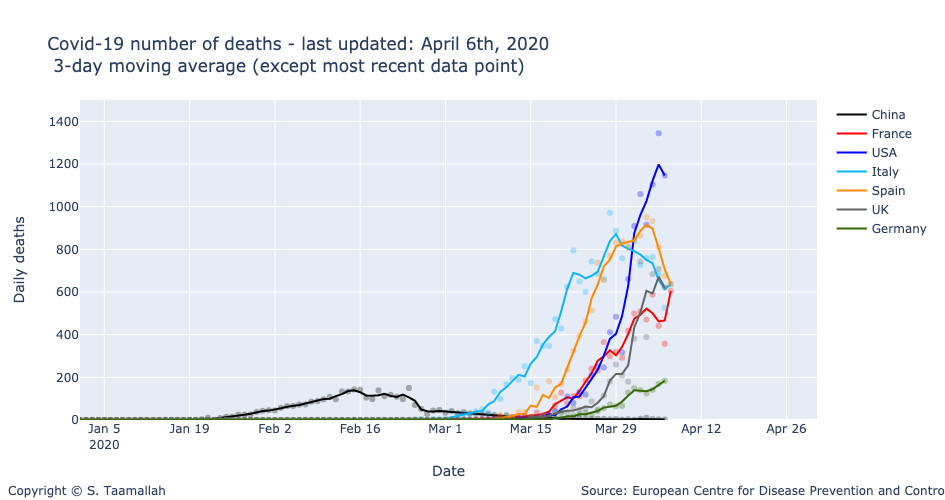

'STaamallah_covid19_analysis_chart_1_20200406.html'

In [74]:
degree = 1
#smooth_italy = smoothTriangle(df_italy['deaths'],degree)

smooth_china = smoothTriangle(df_china['deaths'], degree)
smooth_france = smoothTriangle(df_france['deaths'], degree)
smooth_italy = smoothTriangle(df_italy['deaths'],degree)
smooth_usa = smoothTriangle(df_usa['deaths'],degree)
smooth_uk = smoothTriangle(df_uk['deaths'],degree)
smooth_germany = smoothTriangle(df_germany['deaths'],degree)
smooth_spain = smoothTriangle(df_spain['deaths'],degree)
smooth_korea = smoothTriangle(df_korea['deaths'],degree)
smooth_netherlandss = smoothTriangle(df_netherlands['deaths'],degree)

smooth_china = smooth_3day(df_china['deaths'])
smooth_france = smooth_3day(df_france['deaths'])
smooth_italy = smooth_3day(df_italy['deaths'])
smooth_usa = smooth_3day(df_usa['deaths'])
smooth_uk = smooth_3day(df_uk['deaths'])
smooth_germany = smooth_3day(df_germany['deaths'])
smooth_spain = smooth_3day(df_spain['deaths'])
smooth_korea = smooth_3day(df_korea['deaths'])
smooth_netherlandss = smooth_3day(df_netherlands['deaths'])



# Add traces
trace1 = go.Scatter(
        x=df_china.index, 
        y=df_china['deaths'],
        mode='markers',
        name='China daily cases',
        line_color='rgba(0, 0, 0, .3)',
        showlegend=False,
)

trace11 = go.Scatter(
        x=df_china.index, 
        y=smooth_china,
        mode='lines',
        name='China',
        line_color='rgba(0, 0, 0, 1)',
)


trace2 = go.Scatter(
        x=df_france.index, 
        y=df_france['deaths'],
        mode='markers',
        name='France',
        line_color='rgba(256, 0, 0, .3)',
        showlegend=False,
)

trace22 = go.Scatter(
        x=df_france.index, 
        y=smooth_france,
        mode='lines',
        name='France',
        line_color='rgba(256, 0, 0, 1)',
)


trace3 = go.Scatter(
        x=df_usa.index, 
        y=df_usa['deaths'],
        mode='markers',
        name='USA',
        line_color='rgba(0, 0, 255, .3)',
    showlegend=False,
)

trace33 = go.Scatter(
        x=df_usa.index, 
        y=smooth_usa,
        mode='lines',
        name='USA',
        line_color='rgba(0, 0, 255, 1)',
)

trace4 = go.Scatter(
        x=df_italy.index, 
        y=df_italy['deaths'],
        mode='markers',
        name='Italy',
        line_color='rgba(14, 180, 252, .3)',
    showlegend=False,
)

trace44 = go.Scatter(
        x=df_italy.index, 
        y=smooth_italy,
        mode='lines',
        name='Italy',
        line_color='rgba(14, 180, 252, 1)',
)

trace5 = go.Scatter(
        x=df_spain.index, 
        y=df_spain['deaths'],
        mode='markers',
        name='Spain',
        line_color='rgba(255, 137, 0, .3)',
    showlegend=False,
)

trace55 = go.Scatter(
        x=df_spain.index, 
        y=smooth_spain,
        mode='lines',
        name='Spain',
        line_color='rgba(256, 137, 0, 1)',
)


trace6 = go.Scatter(
        x=df_uk.index, 
        y=df_uk['deaths'],
        mode='markers',
        name='UK',
        line_color='rgba(100, 100, 100, .3)',
    showlegend=False
)

trace66 = go.Scatter(
        x=df_uk.index, 
        y=smooth_uk,
        mode='lines',
        name='UK',
        line_color='rgba(100, 100, 100, 1)',
)

trace7 = go.Scatter(
        x=df_germany.index, 
        y=df_germany['deaths'],
        mode='markers',
        name='Germany',
        line_color='rgba(51, 102, 0, .3)',
    showlegend=False,
)

trace77 = go.Scatter(
        x=df_germany.index, 
        y=smooth_germany,
        mode='lines',
        name='Germany',
        line_color='rgba(51, 102, 0, 1)',
)


data = [trace1,trace11, trace2, trace22, trace3, trace33, trace4, trace44, trace5, trace55, trace6, trace66, trace7, trace77]

layout = go.Layout(
    title="Covid-19 number of deaths - last updated: April 6th, 2020 <br> 3-day moving average (except most recent data point)",
    width=900,
    height=500,
    
    # Top left
    xaxis=dict(
        title='Date',
        range=['2020-01-01', '2020-05-01'],
    ),
    yaxis=dict(
        title='Daily deaths',
        #type='log',
        range=[0,1500],
        anchor='x'
    ),
    
      annotations=[
        dict(
            x=1.18,
            y=-0.25,
            showarrow=False,
            text='Source: European Centre for Disease Prevention and Control',
            xref='paper',
            yref='paper'
        ),
        
        dict(
            x=-0.1,
            y=-0.25,
            showarrow=False,
            text='Copyright © S. Taamallah ',
            xref='paper',
            yref='paper'
        )
    ],
    
)

fig = go.Figure(data=data, layout=layout)

fig.show()

from plotly.offline import plot
plot(fig, filename="STaamallah_covid19_analysis_chart_1_20200406.html", auto_open = False)




# 2 - The China case

In [75]:
# function to smooth the data 

def smooth_9day(data):
    triangle=[1,1,1,1,1,1,1,1,1]
    smoothed=np.zeros(len(data))
    for i in range(4, len(data)-5):
        point=data[i-4:i-4+len(triangle)] * triangle
        smoothed[i] = int(np.sum(point)/np.sum(triangle)) 
        
    # Handle boundaries
    smoothed[0] = (data[0]+data[1]+data[2]) / 3
    smoothed[1] = (data[0]+data[1]+data[2]+data[3]) / 4
    smoothed[2] = (data[0]+data[1]+data[2]+data[3]+data[4]) / 5
    smoothed[3] = (data[0]+data[1]+data[2]+data[3]+data[4]+data[5]) / 6

    smoothed[-1] = (data[-1]+data[-2]+data[-3]) / 3
    smoothed[-2] = (data[-1]+data[-2]+data[-3]+data[-4]) / 4
    smoothed[-3] = (data[-1]+data[-2]+data[-3]+data[-5]) / 5
    smoothed[-4] = (data[-1]+data[-2]+data[-3]+data[-5]+data[-6]) / 6
   
    return smoothed

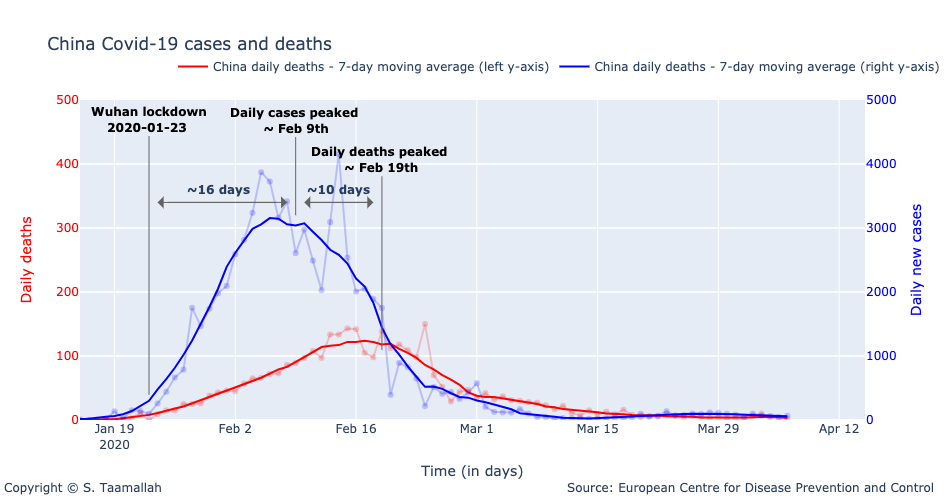

'STaamallah_covid19_analysis_chart_2_20200406.html'

In [76]:
degree = 5

smooth_china_deaths = smoothTriangle(df_china['deaths'],degree)
smooth_china_cases = smoothTriangle(df_china['cases'],degree)

smooth_china_deaths_9day = smooth_9day(df_china['deaths'])
smooth_china_cases_9day = smooth_9day(df_china['cases'])



# Add traces
trace1 = go.Scatter(
        x=df_china.index, 
        y=df_china['deaths'],
        mode='lines + markers',
        name='China daily deaths (left y-axis)',
        line_color='rgba(256, 0, 0, .2)',
        showlegend=False,
)

trace11 = go.Scatter(
        x=df_china.index, 
        y=smooth_china_deaths_9day,
        mode='lines',
        name='China daily deaths - 7-day moving average (left y-axis)',
        line_color='rgba(256, 0, 0, 1)',
)


trace2 = go.Scatter(
        x=df_china.index, 
        y=df_china['cases'],
        mode='lines + markers',
        name='China daily deaths (right y-axis)',
        line_color='rgba(0, 0, 256, .2)',
        showlegend=False,
        yaxis='y2'
)

trace22 = go.Scatter(
        x=df_china.index, 
        y=smooth_china_cases_9day,
        mode='lines',
        name='China daily deaths - 7-day moving average (right y-axis)',
        line_color='rgba(0, 0, 256, 1)',
        yaxis='y2'
)

data = [trace1, trace11, trace2, trace22]

layout = go.Layout(
    title='China Covid-19 cases and deaths',
    legend=dict(x=.4, y=1.15, orientation="h"), 
    width=900,
    height=500,
    
    # Top left
    xaxis=dict(
        title='Time (in days)',
        range=['2020-01-15', '2020-04-15'],
    ),
    yaxis=dict(
        title='Daily deaths',
        #type='log',
        range=[0,500],
        color="red",
        anchor='x'
    ),
    yaxis2=dict(
        title = 'Daily new cases',
        color='rgba(0, 0, 256, 1)',
        #type='log',
        range=[0,5000],
        overlaying='y',
        side='right'
    ),
    
       annotations=[
        dict(
            x=1.09,
            y=-0.24,
            showarrow=False,
            text='Source: European Centre for Disease Prevention and Control',
            xref='paper',
            yref='paper'
        ),
        
        dict(
            x=-0.1,
            y=-0.24,
            showarrow=False,
            text='Copyright © S. Taamallah ',
            xref='paper',
            yref='paper'
        )
    ],
    
)



fig = go.Figure(data=data, layout=layout)

fig.add_annotation(
            x='2020-01-23',
            y=40,
            xref="x",
            yref="y",
            text="<b> Wuhan lockdown <br> 2020-01-23  </b>",
            showarrow=True,
            font=dict(
            #family="Courier New, monospace",
            size=12,
            color="black",
            ),
        align="center",
        arrowhead=0,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor="#636363",
        ax=0,
        ay=-275,
)




fig.add_annotation(
            x='2020-02-09',
            y=320,
            text="<b>Daily cases peaked <br> ~ Feb 9th </b>",
            showarrow=True,
            font=dict(
            #family="Courier New, monospace",
            size=12,
            color="black",
            ),
        align="center",
        arrowhead=0,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor="#636363",
        ax=0,
        ay=-95,
)


fig.add_annotation(
            x='2020-02-19',
            y=110,
            text="<b>Daily deaths peaked <br> ~ Feb 19th </b>",
            showarrow=True,
            font=dict(
            #family="Courier New, monospace",
            size=12,
            color="black",
            ),
        align="center",
        arrowhead=0,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor="#636363",
        ax=0,
        ay=-190,
)

fig.add_annotation(
            x='2020-02-10',
            y=340,
            text="",
            showarrow=True,
            font=dict(
            #family="Courier New, monospace",
            size=12,
            color="black",
            ),
        align="center",
        arrowhead=1,
        arrowsize=2,
        arrowwidth=1,
        arrowcolor="#636363",
        ax=65,
        ay=0,
)

fig.add_annotation(
            x='2020-02-18',
            y=340,
            text="",
            showarrow=True,
            font=dict(
            #family="Courier New, monospace",
            size=12,
            color="black",
            ),
        align="center",
        arrowhead=1,
        arrowsize=2,
        arrowwidth=1,
        arrowcolor="#636363",
        ax=-65,
        ay=0,
)

fig.add_annotation(
            x='2020-02-14',
            y=360,
            text="<b> ~10 days </b>",
            showarrow=False,
)

fig.add_annotation(
            x='2020-01-24',
            y=340,
            text="",
            showarrow=True,
            font=dict(
            #family="Courier New, monospace",
            size=12,
            color="black",
            ),
        align="center",
        arrowhead=1,
        arrowsize=2,
        arrowwidth=1,
        arrowcolor="#636363",
        ax=120,
        ay=0,
)

fig.add_annotation(
            x='2020-02-08',
            y=340,
            text="",
            showarrow=True,
            font=dict(
            #family="Courier New, monospace",
            size=12,
            color="black",
            ),
        align="center",
        arrowhead=1,
        arrowsize=2,
        arrowwidth=1,
        arrowcolor="#636363",
        ax=-120,
        ay=0,
)


fig.add_annotation(
            x='2020-01-31',
            y=360,
            text="<b> ~16 days </b>",
            showarrow=False,
)

fig.show()

from plotly.offline import plot
plot(fig, filename="STaamallah_covid19_analysis_chart_2_20200406.html", auto_open = False)


- Wuhan implemented a full lockdown as early as in january 23rd. At that point, very few people died from the Covid-19 in China and about 500 people tested positive to the virus. The number of cases kept rising sharply in the days after the lockdown measures and an inflection point was observed on Feb 1st, leading to a number of daily cases plateau'ing and reaching a maximum 16 days after the lockdown. The plateau's mid point could be located around february 9th 2020. Meanwhile, the number of death continued to increase and only reached its peak 10 days after the number of daily cases reach its maximum level. 

- 16 and 10 days, those are the two numbers to keep in mind. Of course, it is also important to note that the peak is closer to a plateau and this plateau lasted for about 10 days in China. The peak dates we are extracting here are the mid points of each plateau.

# 3 - When can we expect the peak of epidemic in Europe and the U.S. ?





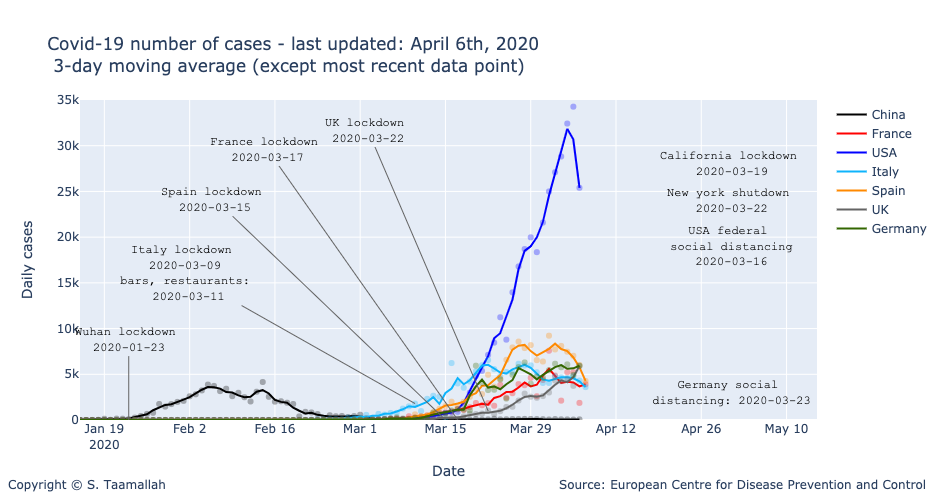

'STaamallah_covid19_analysis_chart_3_20200406.html'

In [77]:
degree = 1
#smooth_italy = smoothTriangle(df_italy['deaths'],degree)

smooth_china = smoothTriangle(df_china['cases'], degree)
smooth_france = smoothTriangle(df_france['cases'], degree)
smooth_italy = smoothTriangle(df_italy['cases'],degree)
smooth_usa = smoothTriangle(df_usa['cases'],degree)
smooth_uk = smoothTriangle(df_uk['cases'],degree)
smooth_germany = smoothTriangle(df_germany['cases'],degree)
smooth_spain = smoothTriangle(df_spain['cases'],degree)
smooth_korea = smoothTriangle(df_korea['cases'],degree)
smooth_netherlandss = smoothTriangle(df_netherlands['cases'],degree)

smooth_china = smooth_3day(df_china['cases'])
smooth_france = smooth_3day(df_france['cases'])
smooth_italy = smooth_3day(df_italy['cases'])
smooth_usa = smooth_3day(df_usa['cases'])
smooth_uk = smooth_3day(df_uk['cases'])
smooth_germany = smooth_3day(df_germany['cases'])
smooth_spain = smooth_3day(df_spain['cases'])
smooth_korea = smooth_3day(df_korea['cases'])
smooth_netherlandss = smooth_3day(df_netherlands['cases'])




# Add traces
trace1 = go.Scatter(
        x=df_china.index, 
        y=df_china['cases'],
        mode='markers',
        name='China daily cases',
        line_color='rgba(0, 0, 0, .3)',
        showlegend=False,
)

trace11 = go.Scatter(
        x=df_china.index, 
        y=smooth_china,
        mode='lines',
        name='China',
        line_color='rgba(0, 0, 0, 1)',
)


trace2 = go.Scatter(
        x=df_france.index, 
        y=df_france['cases'],
        mode='markers',
        name='France',
        line_color='rgba(256, 0, 0, .3)',
        showlegend=False,
)

trace22 = go.Scatter(
        x=df_france.index, 
        y=smooth_france,
        mode='lines',
        name='France',
        line_color='rgba(256, 0, 0, 1)',
)


trace3 = go.Scatter(
        x=df_usa.index, 
        y=df_usa['cases'],
        mode='markers',
        name='USA',
        line_color='rgba(0, 0, 255, .3)',
    showlegend=False,
)

trace33 = go.Scatter(
        x=df_usa.index, 
        y=smooth_usa,
        mode='lines',
        name='USA',
        line_color='rgba(0, 0, 255, 1)',
)
    
    
trace4 = go.Scatter(
        x=df_italy.index, 
        y=df_italy['cases'],
        mode='markers',
        name='Italy',
        line_color='rgba(14, 180, 252, .3)',
    showlegend=False,
)

trace44 = go.Scatter(
        x=df_italy.index, 
        y=smooth_italy,
        mode='lines',
        name='Italy',
        line_color='rgba(14, 180, 252, 1)',
)

trace5 = go.Scatter(
        x=df_spain.index, 
        y=df_spain['cases'],
        mode='markers',
        name='Spain',
        line_color='rgba(255, 137, 0, .3)',
    showlegend=False,
)

trace55 = go.Scatter(
        x=df_spain.index, 
        y=smooth_spain,
        mode='lines',
        name='Spain',
        line_color='rgba(255, 137, 0, 1)',
)


trace6 = go.Scatter(
        x=df_uk.index, 
        y=df_uk['cases'],
        mode='markers',
        name='UK',
        line_color='rgba(100, 100, 100, .3)',
    showlegend=False
)

trace66 = go.Scatter(
        x=df_uk.index, 
        y=smooth_uk,
        mode='lines',
        name='UK',
        line_color='rgba(100, 100, 100, 1)',
)

trace7 = go.Scatter(
        x=df_germany.index, 
        y=df_germany['cases'],
        mode='markers',
        name='Germany',
        line_color='rgba(51, 102, 0, .3)',
    showlegend=False,
)

trace77 = go.Scatter(
        x=df_germany.index, 
        y=smooth_germany,
        mode='lines',
        name='Germany',
        line_color='rgba(51, 102, 0, 1)',
)


data = [trace1,trace11, trace2, trace22, trace3, trace33, trace4, trace44, trace5, trace55, trace6, trace66, trace7, trace77]

layout = go.Layout(
    title="Covid-19 number of cases - last updated: April 6th, 2020 <br> 3-day moving average (except most recent data point)",
    width=900,
    height=500,
    
    # Top left
    xaxis=dict(
        title='Date',
        range=['2020-01-15', '2020-05-15'],
    ),
    yaxis=dict(
        title='Daily cases',
        #type='log',
        range=[0,35000],
        anchor='x'
    ),
    
      annotations=[
        dict(
            x=1.15,
            y=-0.23,
            showarrow=False,
            text='Source: European Centre for Disease Prevention and Control',
            xref='paper',
            yref='paper'
        ),
        
        dict(
            x=-0.1,
            y=-0.23,
            showarrow=False,
            text='Copyright © S. Taamallah ',
            xref='paper',
            yref='paper'
        )
    ],
    
)



fig = go.Figure(data=data, layout=layout)



fig.add_annotation(
        x='2020-01-23',
        y=20,
        xref="x",
        yref="y",
        text="Wuhan lockdown <br> 2020-01-23 ",
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=12,
            color="black"
            ),
        align="center",
        arrowhead=0,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor="#636363",
        ax=0,
        ay=-80,
        #bordercolor="#c7c7c7",
        #borderwidth=2,
        #borderpad=4,
        #bgcolor="#ff7f0e",
        #opacity=0.8
        )


fig.add_annotation(
        x='2020-03-10',
        y=1800,
        xref="x",
        yref="y",
        text="Italy lockdown <br> 2020-03-09 <br> bars, restaurants: <br> 2020-03-11",
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=12,
            color="black"
            ),
        align="center",
        arrowhead=0,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor="#636363",
        ax=-230,
        ay=-130,
        #bordercolor="#c7c7c7",
        #borderwidth=2,
        #borderpad=4,
        #bgcolor="#ff7f0e",
        #opacity=0.8
        )


fig.add_annotation(
            x='2020-03-17',
            y=30,
            text="France lockdown <br> 2020-03-17 ",
            showarrow=True,
            font=dict(
            family="Courier New, monospace",
            size=12,
            color="black",
            ),
        align="center",
        arrowhead=0,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor="#636363",
        ax=-190,
        ay=-270,
)


fig.add_annotation(
            x='2020-03-15',
            y=20,
            text="Spain lockdown <br> 2020-03-15 ",
            showarrow=True,
            font=dict(
            family="Courier New, monospace",
            size=12,
            color="black",
            ),
        align="center",
        arrowhead=0,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor="#636363",
        ax=-230,
        ay=-220,
)


fig.add_annotation(
            x='2020-03-22',
            y=1000,
            text="UK lockdown <br> 2020-03-22 ",
            showarrow=True,
            font=dict(
            family="Courier New, monospace",
            size=12,
            color="black",
            ),
        align="center",
        arrowhead=0,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor="#636363",
        ax=-120,
        ay=-280,
)

fig.add_annotation(
            x='2020-05-01',
            y=3000,
            text="Germany social <br> distancing: 2020-03-23 ",
            showarrow=False,
            font=dict(
            family="Courier New, monospace",
            size=12,
            color="black",
            ),
        align="center",
        arrowhead=0,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor="#636363",
        ax=600,
        ay=-60,
)

fig.add_annotation(
            x='2020-05-01',
            y=19000,
            text="USA federal <br> social distancing <br> 2020-03-16 ",
            showarrow=False,
            font=dict(
            family="Courier New, monospace",
            size=12,
            color="black",
            ),
        align="center",
        arrowhead=0,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor="#636363",
        ax=600,
        ay=-520,
)

fig.add_annotation(
            x='2020-05-01',
            y=24000,
            text="New york shutdown <br> 2020-03-22 ",
            showarrow=False,
            font=dict(
            family="Courier New, monospace",
            size=12,
            color="black",
            ),
        align="center",
        arrowhead=0,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor="#636363",
        ax=600,
        ay=-420,
)



fig.add_annotation(
            x='2020-05-01',
            y=28000,
            text="California lockdown <br> 2020-03-19 ",
            showarrow=False,
            font=dict(
            family="Courier New, monospace",
            size=12,
            color="black",
            ),
        align="center",
        arrowhead=0,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor="#636363",
        ax=600,
        ay=-320,
)

fig.show()
from plotly.offline import plot
plot(fig, filename="STaamallah_covid19_analysis_chart_3_20200406.html", auto_open = False)

#from IPython.display import HTML, display
#display(HTML('STaamallah_covid19_analysis_chart_3_20200403.html'), metadata=dict(isolated=True))


- Italy has been under a national lockdown since March 9th. If we consider here the 10th of March as the effective shutdown day and using a 16 day delay for the number of daily cases to peak (as derived from the China case above), we can expect a peak to be reached around March 26th. In Spain and in France, one can hope for a peak occuring 6 and 8 days later respectively i.e. April 1st and april 3rd. 

- It is interesting to see in the graph above that the number of daily cases in Italy has not increased since March 21nd and remained between 5000 and 6000 per day. A similar observation can be made in Spain with the number of new cases flat since March 27th. 

- If the number of cases indeed peaked in Italy and Spain, then we should expect a peak in the number of daily deaths in Italy around April 5th in Italy, April 11th in Spain and April 13th in France.

- Of course there is an important assumption here; we are assuming that the lockdown in different countries will have the same effect and delay. In reality the degree of stirctness of a lockdown depends on the country and a varying delay and plateau length and shape is to be expected.

In [ ]:
#plotting number of cases and number of deaths for different countries
# all charts using same scale for ease of comparison
# number of death are on the left y-axis. 

# Add traces
trace1 = go.Scatter(
        x=df_china.index, 
        y=df_china['deaths'],
        mode='lines+markers',
        name='Daily deaths (left axis)',
        line_color='rgba(256, 0, 0, .5)',
)
trace2 = go.Scatter(
        x=df_china.index, 
        y=df_china['cases'],
        mode='lines+markers',
        name='Daily cases (right axis)',
        line_color='rgba(0, 0, 256, .5)',
        yaxis='y2'
)
trace3 = go.Scatter(
        x=df_france.index, 
        y=df_france['deaths'],
        mode='lines+markers',
        name='Daily deaths',
        showlegend=False,
        line_color='rgba(256, 0, 0, .5)',
        xaxis='x2',
        yaxis='y3'
)
trace4 = go.Scatter(
        x=df_france.index, 
        y=df_france['cases'],
        mode='lines+markers',
        name='Daily cases',
        line_color='rgba(0, 0, 256, .5)',
        xaxis='x2',
        yaxis='y4',
        showlegend=False,
)
trace5 = go.Scatter(
        x=df_usa.index, 
        y=df_usa['deaths'],
        mode='lines+markers',
        name='Daily deaths',
        line_color='rgba(256, 0, 0, .5)',
        xaxis='x3',
        yaxis='y5',
        showlegend=False,
)
trace6 = go.Scatter(
        x=df_usa.index, 
        y=df_usa['cases'],
        mode='lines+markers',
        name='Daily cases',
        line_color='rgba(0, 0, 256, .5)',
        xaxis='x3',
        yaxis='y6',
        showlegend=False,
)
trace7 = go.Scatter(
        x=df_tunisia.index, 
        y=df_tunisia['deaths'],
        mode='lines+markers',
        name='Daily deaths',
        line_color='rgba(256, 0, 0, .5)',
        xaxis='x4',
        yaxis='y7',
        showlegend=False,
)
trace8 = go.Scatter(
        x=df_tunisia.index, 
        y=df_tunisia['cases'],
        mode='lines+markers',
        name='Daily cases',
        line_color='rgba(0, 0, 256, .5)',
        xaxis='x4',
        yaxis='y8',
        showlegend=False,
)


trace9 = go.Scatter(
        x=df_italy.index, 
        y=df_italy['deaths'],
        mode='lines+markers',
        name='Daily deaths',
        line_color='rgba(256, 0, 0, .5)',
        xaxis='x5',
        yaxis='y9',
        showlegend=False,
)

trace10 = go.Scatter(
        x=df_italy.index, 
        y=df_italy['cases'],
        mode='lines+markers',
        name='Daily cases',
        line_color='rgba(0, 0, 256, .5)',
        xaxis='x5',
        yaxis='y10',
        showlegend=False,
)

trace11 = go.Scatter(
        x=df_spain.index, 
        y=df_spain['deaths'],
        mode='lines+markers',
        name='Daily deaths',
        line_color='rgba(256, 0, 0, .5)',
        xaxis='x6',
        yaxis='y11',
        showlegend=False,
)
trace12 = go.Scatter(
        x=df_spain.index, 
        y=df_spain['cases'],
        mode='lines+markers',
        name='Daily cases',
        line_color='rgba(0, 0, 256, .5)',
        xaxis='x6',
        yaxis='y12',
        showlegend=False,
)

data = [trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8, trace9, trace10, trace11, trace12]

layout = go.Layout(
    title='Covid-19 cases and deaths in China, France, USA, Tunisia, Italy and Spain',
    legend=dict(x=.1, y=1.07, orientation="h"), 
    width=900,
    height=800,
    
    annotations=[
        dict(
            x=1.09,
            y=-0.125,
            showarrow=False,
            text='Source: European Centre for Disease Prevention and Control',
            xref='paper',
            yref='paper'
        ),
        
        dict(
            x=-0.1,
            y=-0.125,
            showarrow=False,
            text='Copyright © S. Taamallah ',
            xref='paper',
            yref='paper'
        )
    ],
    
    # Top left
    xaxis=dict(
        title='China',
        domain=[0, 0.4],
        range=['2020-01-15', '2020-04-15'],
    ),
    yaxis=dict(
        title='Daily deaths',
        #type='log',
        range=[0,200],
        domain=[0.75, 1],
        anchor='x'
    ),
    yaxis2=dict(
        title = 'Daily new cases',
        #type='log',
        range=[0,5000],
        overlaying='y',
        side='right'
    ),
    

    # Top right
    xaxis2=dict(
        title='France',
        range=['2020-01-15', '2020-04-15'],
        domain=[0.6, 1.0],
        anchor='y3'
    ),
    yaxis3=dict(
        #type='log',
        title = 'Daily deaths',
        domain=[0.75, 1],
        anchor='x2',
        range=[0,1000],

    ),
    yaxis4=dict(
        title = 'Daily new cases',
        domain=[0.6, 1.0],
        overlaying='y3',
        range=[0,10000],
        side='right',
        anchor='x2'
    ),

    # middle left
    xaxis3=dict(
        title='USA',
        range=['2020-01-15', '2020-04-15'],
        domain=[0, 0.4],
        anchor='y5'
    ),
    yaxis5=dict(
        #type='log',
        title = 'Daily deaths',
        domain=[0.375, 0.625],
        range=[0,2000],
        anchor='x3'
    ),
    yaxis6=dict(
        title = 'Daily new cases',
        domain=[0.375, 0.625],
        overlaying='y5',
        range=[0,40000],
        side='right',
        anchor='x3'
    ),

    # middle right
    xaxis4=dict(
        title='Tunisia',
        range=['2020-01-15', '2020-04-15'],
        domain=[0.6, 1.0],
        anchor='y7'
    ),
    yaxis7=dict(
        #type='log',
        title = 'Daily deaths',
        domain=[0.375, 0.625],
        range=[0,50],
        anchor='x4'
    ),
    yaxis8=dict(
        title = 'Daily new cases',
        domain=[0.375, 0.625],
        overlaying='y7',
        range=[0,100],
        side='right',
        anchor='x4'
    ),
    
    # Bottom left
    xaxis5=dict(
        title='Italy',
        range=['2020-01-15', '2020-04-15'],
        domain=[0, 0.4],
        anchor='y9'
    ),
    yaxis9=dict(
        #type='log',
        title = 'Daily deaths',
        domain=[0, 0.25],
        range=[0,1200],
        anchor='x5'
    ),
    yaxis10=dict(
        title = 'Daily new cases',
        domain=[0, 0.25],
        overlaying='y9',
        range=[0,30000],
        side='right',
        anchor='x5'
    ),
    
    # Bottom bottom right
    xaxis6=dict(
        title='Spain',
        range=['2020-01-15', '2020-04-15'],
        domain=[0.6, 1.0],
        anchor='y11'
    ),
    yaxis11=dict(
        #type='log',
        title = 'Daily deaths',
        domain=[0, 0.25],
        range=[0,1200],
        anchor='x6'
    ),
    yaxis12=dict(
        title = 'Daily new cases',
        domain=[0, 0.25],
        overlaying='y11',
        range=[0,30000],
        side='right',
        anchor='x6'
    )
    
)


    
fig = go.Figure(data=data, layout=layout)


fig.show()


#py.plot(data, filename = 'basic-line', auto_open=True)
#py.plot(data, filename='privacy-public', sharing='public')

from plotly.offline import plot
plot(fig, filename="STaamallah_covid19_analysis_chart_4_20200406.html", auto_open = False)

#from IPython.display import HTML, display
#display(HTML('STaamallah_covid19_analysis_chart_4_20200403.html'), metadata=dict(isolated=False))